In [1]:
import os
import re
import sys
import json
import pandas as pd
from matplotlib import pyplot as plt

# add project root to system path
sys.path.append(os.path.abspath('../'))

In [1]:
# get folders for each model
runs_dir = "../runs/reddit/implicit/"
run_paths = {}
for path in os.listdir(runs_dir):
    path = os.path.join(runs_dir, path)
    if os.path.isdir(path) and re.search('llama_\d*B(_Q)?', path):
        run_paths[re.search('llama_\d*B(_Q)?', path).group()] = path

# build dataframe
data = []
for model_name, run_path in run_paths.items():
    with open(os.path.join(run_path, 'results.jsonl')) as f:
        for line in f:
            trial_dict = json.loads(line)
            trial_dict['model'] = model_name
            data.append(trial_dict)
df = pd.DataFrame(data)

# fix in context domain is none
df.loc[df['in_context_domain'].isna(), 'in_context_domain'] = 'none'
df

NameError: name 'os' is not defined

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
import numpy as np

# load model for sentiment analysis
model_name = 'cardiffnlp/twitter-roberta-base-sentiment-latest'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, device_map='auto')

# iterate through batches of model answers
model_answers = list(df['model_answer'])
answer_loader = DataLoader(model_answers, batch_size=1024, shuffle=False)
sentiment_scores = []
for batch in answer_loader:
    inputs = tokenizer(batch, truncation=True, padding=True, return_tensors='pt', max_length=512).to(model.device)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=-1).cpu().numpy()
    sentiment_scores.append(probs)

sentiment_scores = np.concat(sentiment_scores, axis=0)
df['sentiment_scores'] = list(sentiment_scores)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
def KL_div(P, Q, eps=1e-12):
    P = np.clip(P, eps, 1)
    Q = np.clip(Q, eps, 1)
    return np.sum(P * np.log(P / Q),  axis=-1)



In [5]:
kl_div_matrices = {}
inquiry_domains = list(df['inquiry_domain'].unique())

n_context_domains = len(list(df['in_context_domain'].unique())) - 1

model_names = list(run_paths.keys())
for model_name in model_names:
    KL_mat = []
    for inq_domain in inquiry_domains:
        df_filter = (df['model'] == model_name) & (df['inquiry_domain'] == inq_domain)
        sub_df = df[df_filter]

        # take the mean over each iteration
        groupby_cols = ['inq_doc_idx', 'in_context_domain', 'inquiry_domain']
        sentiment_df = sub_df[[*groupby_cols, 'sentiment_scores']].groupby(groupby_cols).mean().reset_index()  

        # shape (n_inq_samples, 3)
        prior_sentiments = np.stack(sentiment_df[sentiment_df['in_context_domain'] == 'none']['sentiment_scores'].values)
        
        # shape (n_inq_samples, n_in_context_domains, 3)
        post_sentiments = np.stack(sentiment_df[sentiment_df['in_context_domain'] != 'none']['sentiment_scores'].values).reshape(-1, n_context_domains, 3)
        
        # shape (n_inq_samples, n_in_context_domains)
        per_sample_KL = KL_div(prior_sentiments[:, np.newaxis, :], post_sentiments)
        KL_mat.append(per_sample_KL)
    # shape (n_inq_domains, n_inq_samples, n_in_context_domains)
    KL_mat = np.stack(KL_mat, axis=0)
    # shape (n_inq_domains, n_in_context_domains, n_inq_samples)
    kl_div_matrices[model_name] = KL_mat.transpose(0, 2, 1)

In [6]:
in_context_domains = list(sentiment_df['in_context_domain'][:11])
in_context_domains.remove('none')

In [11]:
# reorder matrices so the heatmaps are nicer
inquiry_domains_array = np.array(inquiry_domains)
inquiry_domains_argsort = inquiry_domains_array.argsort()
inquiry_domains_array = inquiry_domains_array[inquiry_domains_argsort]
inquiry_domains = inquiry_domains_array.tolist()

in_context_domains_array = np.array(in_context_domains)
in_context_domains_argsort = in_context_domains_array.argsort()
in_context_domains_array = in_context_domains_array[in_context_domains_argsort]
in_context_domains = in_context_domains_array.tolist()

for model_name, kl_div_matrix in kl_div_matrices.items():
    arr = kl_div_matrix[inquiry_domains_argsort, :, :]
    arr = arr[:, in_context_domains_argsort, :]
    kl_div_matrices[model_name] = arr

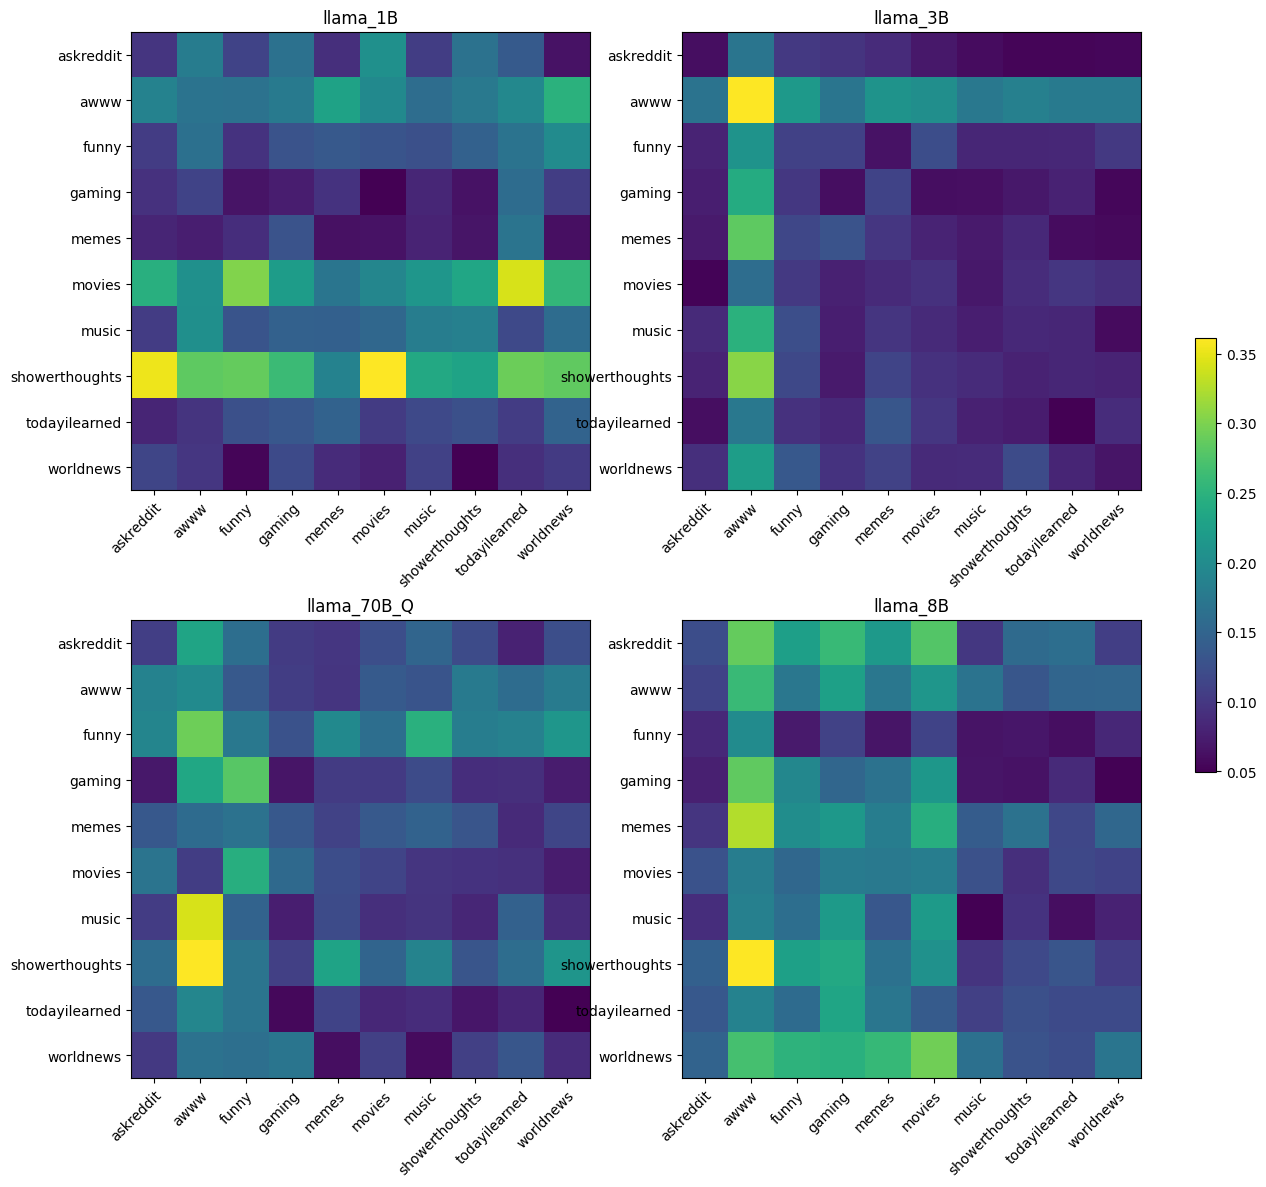

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
axes = axes.flatten()
for i, ax in enumerate(axes):
    model_name = model_names[i]
    heatmap = ax.imshow(kl_div_matrices[model_name].mean(axis=-1), cmap='viridis')
    ax.set_yticks(np.arange(len(inquiry_domains)))
    ax.set_yticklabels(inquiry_domains)

    ax.set_xticks(np.arange(len(in_context_domains)))
    ax.set_xticklabels(in_context_domains)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    ax.set_title(model_name)

fig.colorbar(heatmap, ax=axes, orientation='vertical', fraction=0.02)
plt.show()

,in_context_domain,inquiry_domain,in_context_doc_indices,inq_doc_idx,question_order,output_instance_number,gen_time,model_answer,n_input_tokens,n_output_tokens,model,sentiment_scores
0,funny,funny,"[98, 84, 55, 49, 39, 53, 36, 37, 87, 45]",0,[0],1,7.439453,"Based on the provided content chunks, here are...",3494,475,llama_1B,"[0.07252986, 0.82528925, 0.10218086]"
1,funny,funny,"[98, 84, 55, 49, 39, 53, 36, 37, 87, 45]",0,[0],2,2.382785,"Based on your previous content consumption, it...",3494,263,llama_1B,"[0.027978605, 0.56092805, 0.4110934]"
2,funny,funny,"[98, 84, 55, 49, 39, 53, 36, 37, 87, 45]",0,[0],3,3.923434,"Based on the NEW content chunk, here are the m...",3494,437,llama_1B,"[0.012690505, 0.7445192, 0.2427903]"
3,funny,funny,"[98, 84, 55, 49, 39, 53, 36, 37, 87, 45]",0,[0],4,1.503070,"Based on the NEW content chunk, the main takea...",3494,165,llama_1B,"[0.016070575, 0.49119246, 0.49273694]"
4,funny,funny,"[98, 84, 55, 49, 39, 53, 36, 37, 87, 45]",0,[0],5,2.556063,"Based on your prior content consumption, I've ...",3494,284,llama_1B,"[0.020193834, 0.85120535, 0.12860087]"
...,...,...,...,...,...,...,...,...,...,...,...,...
35195,none,showerthoughts,None,19,[0],1,6.954500,"Based on the NEW content chunk, the main takea...",1112,399,llama_8B,"[0.012826695, 0.5775104, 0.40966293]"
35196,none,showerthoughts,None,19,[0],2,6.860703,"Based on the NEW content chunk, here are the m...",1112,394,llama_8B,"[0.014105061, 0.5810525, 0.40484244]"
35197,none,showerthoughts,None,19,[0],3,5.633296,"Based on the provided NEW content chunk, the m...",1112,323,llama_8B,"[0.005828397, 0.25058028, 0.74359137]"
35198,none,showerthoughts,None,19,[0],4,5.964502,The main takeaways from this NEW content chunk...,1112,342,llama_8B,"[0.023347544, 0.6784749, 0.29817757]"


In [15]:
model.config

RobertaConfig {
  "_attn_implementation_autoset": true,
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "neutral",
    "2": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 0,
    "neutral": 1,
    "positive": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.51.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}